In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.impute import KNNImputer
from collections import Counter

# For Int
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats as ss


# For PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot
import matplotlib.pyplot as plt

In [2]:
# will we draw all?
draw_boxplots_flag = False
draw_histplots_flag = False
draw_first_histplot_flag = False

In [3]:
DRAW_DATA_SEX_PCA = "./draw_data/sex_pca.tsv"
DRAW_DATA_DEATH_PCA = "./draw_data/death_pca.tsv"

PHENO_BEFORE = "./data/extra_FINAL_PHENO_ALL_LAUNCHES.tsv"
PHENO_FOR_R_PLOTS = "draw_data/boxplots_analyses.tsv"
PHENO_TO_SAVE = "data/pheno_filtered_INT_sd3.tsv"
PHENO_UNNORM_TO_SAVE = "data/pheno_filtered_without_INT_sd3.tsv"

In [4]:
def print_info(data):
    print(data.info())
    print(f"\n### Shape:{data.shape}\n")
    print(f"\n### Percentage of not-nans:")
    for key, value in data.iteritems():
        print("--------------------")
        print(
            f"{key}: {np.round((~data[key].isna()).sum()/data[key].shape[0]*100, 1)}%"
        )
    print("\n### Columns and Unique Values:")
    for key, value in data.iteritems():
        print("--------------------")
        print(f"Columns: {key}")
        print(f"Amount of unique values: {value.unique().shape}")
        print(f"Values: {value.unique()}")

        print("--------------------")


def draw_histplots(data, cols, flag=True):
    if flag:
        for col in cols:
            sns.histplot(data[col])
            plt.show()


def impute(data, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return pd.DataFrame(
        imputer.fit_transform(data), columns=data.columns, index=data.index
    )


# from: https://github.com/edm1/rank-based-INT
def rank_INT(series, c=3.0 / 8, stochastic=True):
    """Perform rank-based inverse normal transformation on pandas series.
    If stochastic is True ties are given rank randomly, otherwise ties will
    share the same value. NaN values are ignored.
    Args:
        param1 (pandas.Series):   Series of values to transform
        param2 (Optional[float]): Constand parameter (Bloms constant)
        param3 (Optional[bool]):  Whether to randomise rank of ties

    Returns:
        pandas.Series
    """

    # Check input
    assert isinstance(series, pd.Series)
    assert isinstance(c, float)
    assert isinstance(stochastic, bool)

    # Set seed
    np.random.seed(123)

    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))

    return transformed


def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2 * c + 1)
    return ss.norm.ppf(x)


def do_pca(data, target):

    #     target = 'Severity'
    #     target = 'Death'

    y = data.loc[:, [target]].values
    #     imputed_DF = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data))

    numerical_special_cols = list(set(numerical_cols) & set(data.columns))
    imputed_DF = pd.DataFrame(
        KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(
            data[numerical_special_cols]
        )
    )
    imputed_DF.columns = numerical_special_cols
    imputed_DF.index = data.index
    data = imputed_DF

    x = data.loc[:, numerical_special_cols].values  # Separating out the target

    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    principal_data = pd.DataFrame(
        data=principal_components,
        columns=["principal component 1", "principal component 2"],
        index=data.index,
    )
    principal_data[target] = y
    #     final_data =
    #     final_data = pd.concat([, pd.Series(y)], axis = 1)
    # объясненная дисперсия
    print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
    return principal_data


def draw_pca(final_data, target, targets=None, colors=None):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title(f"2 component PCA by {target}", fontsize=20)

    if not targets:
        targets = final_data[target].unique()
    if not colors:
        colors = ["r", "g", "b", "fuchsia", "sienna"]

    for cur_target, color in zip(targets, colors):
        indicesToKeep = final_data[target] == cur_target
        ax.scatter(
            final_data.loc[indicesToKeep, "principal component 1"],
            final_data.loc[indicesToKeep, "principal component 2"],
            c=color,
            s=50,
        )
    ax.legend(targets)
    ax.grid()
    plt.show()


def delete_outliers(data, sd=3):
    return data.mask(data.sub(data.mean()).div(data.std()).abs().gt(sd))


def high_coverage(data, cutoff):
    cov = dict()
    cov_cols = []
    for key, value in data.iteritems():
        flag = (~data[key].isna()).sum() / data[key].shape[0] * 100 > cutoff
        cov.update({key: flag})
        if flag:
            cov_cols.append(key)
    print(f"Values > {cutoff}%: " + str(Counter(cov.values())))
    return cov_cols

## Data exploration

In [43]:
data = pd.read_csv(PHENO_BEFORE, sep="\t", index_col="launch_blood_id")
print(data.shape)
data.tail()

(840, 127)


,launch_id,man_id,storm,ill_to_hosp,temp,chd,aks,cvd,news_1,resp_fail_5,...,l_max_min,ldh_max_min,fer_max_min,d_dym_max_min,creat_max_min,glu_max_min,pcr_max_min,news,news_max_min,week_to_hosp
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
114118,11,660644,1.0,8.0,1.0,0.0,0.0,0.0,6.0,3.0,...,0.87,0.0,49.7,NaN,3.0,0.00,0.00,11.0,9.0,1.0
114119,11,660141,1.0,7.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.48,NaN,434.2,1.58,11.0,5.75,7.90,5.0,5.0,0.0
114120,11,29478,1.0,3.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.43,0.0,9.4,0.00,NaN,NaN,0.00,4.0,4.0,NaN
114121,11,660907,1.0,6.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.33,0.0,125.4,NaN,13.0,1.13,7.01,4.0,4.0,0.0
114122,11,661492,1.0,9.0,1.0,0.0,0.0,0.0,6.0,2.0,...,0.29,0.0,597.4,0.04,1.0,0.00,NaN,8.0,8.0,1.0


In [44]:
# get indexes, where com_index = 4
com_4_indexes = data[data.com_index == 4].index

In [45]:
print_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 104555 to 114122
Columns: 127 entries, launch_id to week_to_hosp
dtypes: float64(122), int64(2), object(3)
memory usage: 840.0+ KB
None

### Shape:(840, 127)


### Percentage of not-nans:
--------------------
launch_id: 100.0%
--------------------
man_id: 100.0%
--------------------
storm: 97.5%
--------------------
ill_to_hosp: 45.4%
--------------------
temp: 69.4%
--------------------
chd: 70.5%
--------------------
aks: 70.5%
--------------------
cvd: 70.4%
--------------------
news_1: 56.1%
--------------------
resp_fail_5: 50.4%
--------------------
news_5: 50.5%
--------------------
resp_fail_out: 55.5%
--------------------
il6: 63.6%
--------------------
crp: 92.7%
--------------------
leuk: 93.7%
--------------------
neut: 93.7%
--------------------
l: 95.1%
--------------------
ldh: 43.3%
--------------------
fer: 53.5%
--------------------
d_dym: 59.4%
--------------------
creat: 92.1%
--------------------
glu: 5

Amount of unique values: (142,)
Values: [    nan  317.8   241.4    45.4   574.    944.9   362.8   246.7   230.6
  157.6   344.4   186.4    66.1   283.7   266.6  1502.3   765.4   358.6
   77.4   843.    479.8   672.6   198.3    74.4   264.1  1378.5    84.4
  209.    432.4   974.7    32.9   222.8    81.5   122.5   817.6   582.
  589.2   297.8   854.9   679.6   253.4   211.2  1148.9   194.2   472.5
 1472.8  1277.5   765.1   125.2   106.7    40.6   803.    181.    717.5
  414.9  1481.3   402.    630.9   815.9   270.2   413.9   118.    397.
  973.2    40.8   301.7   192.8  3400.    255.9  1183.7   307.8   422.
  248.2   412.2    72.4  1458.6   750.    659.4  1838.    549.    930.
  321.    455.4  2254.9   252.6   517.5  1212.3  1831.3    98.9   335.5
 1258.9   472.4   513.5   382.8   790.8   528.6  1244.7   763.   1061.16
  403.4   166.1   910.6  1494.2   285.    912.8   490.6   121.6  1024.5
  688.2   579.    664.5   687.1  1308.6  1369.3  1000.7   886.2   666.7
  598.5   487.8   974.    1

In [46]:
rename_mapping = {
    "возраст": "age",
    "Пол ( 1-м, 2-ж)": "sex",
    "ЛЕЧЕНИЕ": "treatment",
    "Комп. № пац.-та": "man_id",
    "Индекс коморбидности Чарлсона, общий балл": "com_index",
    "10-летняя выживаемость,% https://www.thecalculator.co/health/Charlson-Comorbidity-Index-(CCI)-Calculator-765.html": "ten_immortality",
    "Диагноз заболевания по МКБ при выписке (1- U 07.1,  2- U 07.2)": "isc_diagn",
    "Степень тяжести заболевания (1-легкая, 2-средняя, 3-тяжелая и кр.тяжелая)": "severity",
    "Степень дыхательной недостаточности при поступлении": "resp_dis_init",
    "NEWS при поступлении (сумма баллов):": "news_init",
    "Степень дыхательной недостаточности к началу терапии": "resp_dis_start",
    "NEWS к началу терапии (сумма баллов):": "news_start",
    "Степень дыхательной недостаточности при выписке": "resp_dis_out",
    "NEWS при выписке (сумма баллов):": "news_out",
    "Форма забол. по КТ 1-4 при поступлении": "CT_init",
    "1": "ct1_init",  ##
    "2": "ct2_init",  ##
    "Форма забол. по КТ 1-4 к началу терапии": "CT_start",
    "1.1": "ct1_start",  ##
    "2.1": "ct2_start",  ##
    "Форма забол. по КТ 1-4 при выписке": "CT_out",
    "1.2": "ct1_out",  ##
    "2.2": "ct2_out",  ##
    "КТ-признаки восстановления пневматизации в динамике": "CT_features",  ##
    "Дата заболевания": "date_in",
    "Дата поступления": "date_out",
    "Количество суток с начала заболевания до госпитализации": "days_to_hosp",
    "Количество суток с начала заболевания до начала антицитокиновой терапии  (- если не применялась)": "days_to_anticyt_treat",
    "Название антицитокинового препарата (1-тоцилизумаб, 2-тофацитиниб, 3-руксолитиниб, 4-RH104, 5-канакинумаб, 6-олокизумаб, 7-радотиниб, 8-барицитиниб, 9-левилимаб, - если не применялся)": "anticyt_treat",
    "Количество суток с начала заболевания до начала применения COVID-плазмы (- если не применялась)": "days_to_covid_plasma_treat",
    "Количество суток с начала заболевания до начала гемосорбции (- если не применялась)": "days_to_hemosorption",
    "Применение системных кортикостероидов (нет-0/да-1)": "systemic_corticosteroids_usage",
    "Количество суток с начала заболевания до начала инв ИВЛ  (- если не применялась)": "days_to_inv_IVL",
    "Количество суток с начала заболевания до начала ЭКМО (- если не применялась)": "days_to_EKMO",
    "Количество суток на ИВЛ": "imv_days",
    "МазокПЦР1": "pcr_1",
    "Лейк1": "leuk_1",
    "Нейтр1": "neut_1",  # нейтрофилы(?)
    "Л1": "l_1",  # ??
    "ЛДГ1": "ldh_1",  # Лактатдегидрогеназа
    "СРБ1": "crp_1",  # с-реактивный белок
    "Фер1": "fer_1",
    "Д-димер1": "d_dym_1",
    "ИЛ-6_1": "il6_1",
    "Креатинин1": "creat_1",
    "Глюкоза1": "glu_1",
    "МазокПЦР3": "pcr_3",
    "Лейк3": "leuk_3",
    "Нейтр3": "neut_3",
    "Л3": "l_3",
    "ЛДГ3": "ldh_3",
    "СРБ3": "crp_3",
    "Фер3": "fer_3",
    "Д-димер3": "d_dym_3",
    "ИЛ-6_3": "il6_3",
    "Креатинин3": "creat_3",
    "Глюкоза3": "glu_3",
    "Мазок ПЦР5": "pcr_5",
    "Лейк5": "leuk_5",
    "Нейтр5": "neut_5",
    "Л5": "l_5",
    "ЛДГ5": "ldh_5",
    "СРБ_5": "crp_5",
    "Фер_5": "fer_5",
    "Д-димер5": "d_dym_5",
    "ИЛ-6_5": "il6_5",
    "Креатинин5": "creat_5",
    "Глюкоза5": "glu_5",
    "Лейк7": "leuk_7",
    "Нейтр7": "neut_7",
    "Л7": "l_7",
    "ЛДГ7": "ldh_7",
    "СРБ_7": "crp_7",
    "Фер_7": "fer_7",
    "Д-димер7": "d_dym_7",
    "ИЛ-6_7": "il6_7",
    "Креатинин7": "creat_7",
    "Глюкоза7": "glu_7",
    "Мазок ПЦР 9-10": "pcr_9",
    "Прокальцитонин": "pct",  # Procalcitonin (hehh???)
    "Исходы (1 умер, 2 выписка)": "death",
    "Степень тяжести заболевания (1-легкая, 2-средняя, 3-тяжелая и кр.тяжелая, 0-не болел)": "severity",  
    "Потеря обонания и вкуса": "smell_taste_loss",
    "Слабость": "weakness",
    "Исходы заболевания(-1 умер, 0-продолжает лечение, 1 выписка)": "current_situation",
    "Койко-дней": "days_at_hosp",
}
cols_to_eng = {
    "от куда пациент": "from",
    "N ПАЦИЕНТА(КРОВЬ)": "blood_id",
    "Пол ( 1-м, 2-ж)": "sex",
    "КАРТА ПАЦ-ТА": "man_id",
    "Количество суток с начала заболевания до госпитализации": "ill_to_hosp",
    "Дата начала лечения": "date_start_treat",
    "День заболевания": "date_ill",
    "Исходы (1 умер, 2 выписка)": "death",
    "Степень тяжести заболевания (1-легкая, 2-средняя, 3-тяжелая и кр.тяжелая)": "severity",
    "ДАТА РОЖДЕНИЯ (ВОЗРАСТ)": "age",
    "СЕКВЕНАТОР": "seq_machine",
    "НАЗВАНИЕ БИБЛИОТЕКИ (ЗАПУСКА)": "launch_name",
    "ДАТА ЗАПУСКА": "launch_date",
    "ИНДЕКС": "index",
    "ГРУППА": "group",
    "ЛЕЧЕНИЕ": "treatment",
    "Койко-дней": "days_at_hosp",
    "Мутаци в гене ITGAM": "ITGAM_mut",
    "rs мутации": "rs_mut",
    "Повышение температуры": "temp",
    "Слабость": "weakness",
    "Потеря обонания и вкуса": "smell_taste_loss",
    "ИБС": "chd",  # ишемическая болезнь сердца
    "АКС": "aks",  # ??
    "ЦВБ": "cvd",  # Цереброваскулярная болезнь
    "Количество суток на ИВЛ": "imv_days",
    "МазокПЦР1": "pcr_1",
    "Лейк1": "leuk_1",
    "Нейтр1": "neut_1",  # нейтрофилы(?)
    "Л1": "l_1",  # ??
    "ЛДГ1": "ldh_1",  # Лактатдегидрогеназа
    "СРБ1": "crp_1",  # с-реактивный белок
    "Фер1": "fer_1",
    "Д-димер1": "d_dym_1",
    "ИЛ-6_1": "il6_1",
    "Креатинин1": "creat_1",
    "Глюкоза1": "glu_1",
    "МазокПЦР3": "pcr_3",
    "Лейк3": "leuk_3",
    "Нейтр3": "neut_3",
    "Л3": "l_3",
    "ЛДГ3": "ldh_3",
    "СРБ3": "crp_3",
    "Фер3": "fer_3",
    "Д-димер3": "d_dym_3",
    "ИЛ-6_3": "il6_3",
    "Креатинин3": "creat_3",
    "Глюкоза3": "glu_3",
    "Мазок ПЦР5": "pcr_5",
    "Лейк5": "leuk_5",
    "Нейтр5": "neut_5",
    "Л5": "l_5",
    "ЛДГ5": "ldh_5",
    "СРБ_5": "crp_5",
    "Фер_5": "fer_5",
    "Д-димер5": "d_dym_5",
    "ИЛ-6_5": "il6_5",
    "Креатинин5": "creat_5",
    "Глюкоза5": "glu_5",
    "Лейк7": "leuk_7",
    "Нейтр7": "neut_7",
    "Л7": "l_7",
    "ЛДГ7": "ldh_7",
    "СРБ_7": "crp_7",
    "Фер_7": "fer_7",
    "Д-димер7": "d_dym_7",
    "ИЛ-6_7": "il6_7",
    "Креатинин7": "creat_7",
    "Глюкоза7": "glu_7",
    "Мазок ПЦР 9-10": "pcr_9",
    "Прокальцитонин": "pct",  # Procalcitonin (hehh???)
    "NEWS при поступлении (сумма баллов):": "news_1",  # National Early Warning Score (NEWS)
    "Степень дыхательной недостаточности на 5й день от поступления: ": "resp_fail_5",
    "NEWS на 5й день от поступления": "news_5",
    "Степень дыхательной недостаточности при выписке": "resp_fail_out",
    "NEWS при выписке (сумма баллов):": "news_out",
    'ШТОРМ 1-да, 0-нет':'storm',
 'Цитокины Биобанк':'cytokines_biobank',
 'Кашель':'cough',
 'Одышка':'sydpnea',
 'Тяжесть в груди':'chest_heaviness',
 'СД':'diabetes', #????
 'Рав.артрит (или другие автоиммуные заб)':'autoimmune',
 'ХБП 3-5':'ckd_3_5', #chronic kidney disease
 'ХОБЛ':'COPD', #Chronic obstructive pulmonary disease 
 'Бронхиальная астма':'asthma',
 'Хронический бронхит':'bronchitis',
 'ГБ':'hypertension', #????
 'ОИМ (свежий)':'mi', #Острый инфаркт миокарда Myocardial infarction
 'Состояние после инфаркта (ПИКС)':'PIKS', #Постинфарктный кардиосклероз 
 'Нарушения ритма':'arrhythmia',
 'ХСН (0-нет, 1-да) ':'chf', #Хроническая сердечная недостаточность
 'Риск ССО':'heart_score',
 'Другое':'other', #???
 'ОНМК (свежий)':'cerebral_infarction', #острое нарушение мозгового кровообращения
 'Тип ОНМК (1-ишемический, 2-геморрагический)':'cerebral_infarction_type_1i_2h',
 'Последствия ОНМК':'cerebral_infarction_effects',
 'Другое.1':'other_1',
 'Онкологические заболевания':'oncology',
 'Стадия':'stage_cancer', #??
 'Первичный очаг':'primary_focus_cancer',
 'Свежие операции или травмы':'fresh_surgery',
 'Операции в анамнезе':'anamnes_surgery',
 'Заболевания ЖКТ':'git_diseases',
 'Заболевания почек':'kidneys_diseases',
 'Анемия':'anemia',
 'Степень анемии (1-легкая, 2-средняя, 3-тяжелая)':'anemia_stage',
 'Хроническая ЛОР-патология':'chronic_ent_pathology',
 'Ожирение':'obesity',
 'Степень':'obesity_stage', #???
 'Другое.2':'other_2',
 'Степень дыхательной недостаточности при поступлении':'respiratory_failure_stage_day0',
 'Интраальвеолярный отёк':'intraalveolar_edema',
 'Полнокровие кровеносных сосудов':'blood_vessels_congestion',
 'Деструктивно-продуктивный васкулит':'destructive-productive_vasculitis',
 'Cладжи эритроцитов с их лизисом в их просветах':'erythrocytes_lysis_in_lumens',
 'Периваскулярные кровоизлияния':'perivascular_hemorrhage',
 'Тромбоэмболы в просветах ветвей легочной артерии':'pulmonary_artery_thromboemboli',
 'Фибриновые тромбы в просветах ветвей легочной артерии':'pulmonary_artery_fibrin_clots',
 'Организующиеся тромбы в просветах ветвей легочной артерии':'pulmonary_artery_trombs',
 'Фибриновые тромбы  в просветах ветвей легочных вен':'pulmonary_veins_fibrin_clots',
 'Организующиеся тромбы в просветах ветвей легочных вен':'pulmonary_veins_trombs',
 'Внутриальвеолярные кровоизлияния':'intraalveolar_hemorrhage',
 'Скопление фибрина в просветах альвеол':'alveoli_fibrin_accumulation',
 'Лимфо-макрофагальная инфильтрация интраальвеолярно':'lympho_macrophage_infiltration_intra-alveolar',
 'Гиалиновые мембраны (протяжённость)':'hyaline_membranes_length',
 'Гиалиновые мембраны толщина (% S от Р)':'hyaline_membranes_percent',
 'Атипичные альвеолоциты':'atypical_alveolocytes',
 'Десквамированные уродливой формы альвеолоциты 2 типа с интрацитоплазматическими включениями в просвете альвеол':'desquamated_ugly_type_2_alveolocytes_with_intracytoplasmic_inclusions_in_the_lumen_of_the_alveoli',
 'Симпласты':'symplasts',
 'Плоскоклеточная метаплазия':'squamous_metaplasia',
 'Десквамация эпителия бронхов':'bronchial_epithelium_desquamation',
 'Спазм мелких бронхов':'small_bronchial_spasm',
 'Десквамированный альвеолярный эпителий в просветах альвеол':'desquamated_alveolar_epithelium_in_the_lumen_of_the_alveoli',
 'Амилоидные тельца':'amyloid_bodies',
 'Фиброз межальвеолярных перегородок':'fibrosis_of_interalveolar_septa',
 'Интерстициальный отёк':'interstitial_edema',
 'Утолщение межальвеолярных перегородок за счет склероза':'thickening ofthe_interalveolar_septa_due_to_sclerosis',
 'Лимфо-макрофагальная инфильтрация межальвеолярных перегородок ':'lympho_macrophage_infiltration_of_interalveolar_septa',
 'Аспирационная пневмония (инородные частицы в просвете терминальной бронхиолы)':'aspiration_pneumonia',
}
from collections import defaultdict
eng2russian = defaultdict(str)
for key in rename_mapping:
    eng2russian[rename_mapping[key]] = key
for key in cols_to_eng:
    eng2russian[cols_to_eng[key]] = key

In [48]:
eng2russian['age']

'ДАТА РОЖДЕНИЯ (ВОЗРАСТ)'

In [54]:
from collections import defaultdict
cols = numerical_cols+categorical_cols
russian_name = defaultdict(str)
coverage_dict = defaultdict(str)
type_of_col = defaultdict(str)
straight = defaultdict(str)
for key in cols:
    straight[key] = key
    russian_name[key] = eng2russian[key]
    type_of_col[key] = "continuous" if key in numerical_cols else "categorical" 
    try:
        coverage_dict[key] =  f"{np.round((~data[key].isna()).sum()/data[key].shape[0]*100, 1)}%" 
    except KeyError:
        print(key)
        coverage_dict[key] =  f"{np.round((~masked_data[key].isna()).sum()/masked_data[key].shape[0]*100, 1)}%"

pc1
pc2


In [64]:
features_data = pd.DataFrame(index=set(cols), columns=['Russian name', 'English name', 'English abbreviation', 'Type of feature', 'Coverage'])
features_data['Russian name'] = features_data.index.map(russian_name)
features_data['English abbreviation'] = features_data.index.map(straight)
features_data['Type of feature'] = features_data.index.map(type_of_col)
features_data['Coverage'] = features_data.index.map(coverage_dict)
features_data

,Russian name,English name,English abbreviation,Type of feature,Coverage
resp_dis_init,Степень дыхательной недостаточности при поступ...,NaN,resp_dis_init,categorical,76.2%
days_to_hosp,Количество суток с начала заболевания до госпи...,NaN,days_to_hosp,continuous,99.0%
leuk_3,Лейк3,NaN,leuk_3,continuous,82.1%
days_at_hosp,Койко-дней,NaN,days_at_hosp,continuous,99.6%
news,,NaN,news,categorical,99.6%
news_dynam,,NaN,news_dynam,categorical,99.6%
death,"Исходы (1 умер, 2 выписка)",NaN,death,categorical,97.0%
news_init,NEWS при поступлении (сумма баллов):,NaN,news_init,categorical,99.8%
leuk_dynam,,NaN,leuk_dynam,continuous,93.7%
neut_dynam,,NaN,neut_dynam,continuous,93.7%


In [77]:
english_full = {
"creat":"Maximum Creatinine Level", #
"creat_1":"Creatinine level on day 1", #Креатинин1
"creat_dynam":"Dynamics of Сreatinine level", #
"creat_max_min":"Maximum Creatine Level Difference", #
"crp":"Maximum C-reactive protein Level", #
"crp_1":"C-reactive protein level on day 1", #СРБ1
"crp_dynam":"Dynamics of C-reactive protein level", #
"crp_max_min":"Maximum C-reactive protein Level Difference", #
"days_at_hosp":"Number of days in the hospital", #Койко-дней
"days_to_hosp":"Days from illness onset to hospitalization", #Количество суток с начала заболевания до госпитализации
"l":"Maximum Lymphocyte Level", #
"l_1":"Lymphocyte level on day 1", #Л1
"l_3":"Lymphocyte level on day 3", #Л3
"l_dynam":"Dynamics of Lymphocyte level", #
"l_max_min":"Maximum Lymphocyte Level Difference", #
"leuk":"Maximum Leukocytes Level", #
"leuk_1":"Leukocytes level on day 1", #Лейк1
"leuk_3":"Leukocytes level on day 3", #Лейк3
"leuk_7":"Leukocytes level on day 7", #Лейк7
"leuk_dynam":"Dynamics of Leukocytes level", #
"leuk_max_min":"Maximum Leukocytes Level Difference", #
"neut":"Maximum Neutrophils Level", #
"neut_1":"Neutrophils level on day 1", #Нейтр1
"neut_3":"Neutrophils level on day 3", #Нейтр3
"neut_dynam":"Dynamics of Neutrophils level", #
"neut_max_min":"Maximum Neutrophils Level Difference", #
"pc1":"The first principal component", #
"pc2":"The second principal component", #
"BACT_sum":"Number of bacterial species detected", #
"CT_features":"CT signs of pneumatization recovery in dynamics", #КТ-признаки восстановления пневматизации в динамике
"CT_init":"Level of disease (according to computed tomography scan) at admission", #Форма забол. по КТ 1-4 при поступлении
"CT_out":"Level of disease (according to computed tomography scan) at discharge", #Форма забол. по КТ 1-4 при выписке
"CT_start":"Level of disease (according to computed tomography scan) at the beginning of therapy", #Форма забол. по КТ 1-4 к началу терапии
"age":"Age", #ДАТА РОЖДЕНИЯ (ВОЗРАСТ)
"com_index":"Charlson Comorbidity Index", #Индекс коморбидности Чарлсона, общий балл
"current_situation":"Disease outcomes (-1  - died, 0  - continues treatment, 1 - discharged)", #Исходы заболевания(-1 умер, 0-продолжает лечение, 1 выписка)
"death":"Outcome(1 - death, 0 - alive)", #Исходы (1 умер, 2 выписка)
"news":"Maximum NEWS index", #
"news_dynam":"Dynamics of NEWS index", #
"news_init":"NEWS index at admiddion", #NEWS при поступлении (сумма баллов):
"news_max_min":"Maximum News index Difference", #
"news_out":"NEWS index at discharge", #NEWS при выписке (сумма баллов):
"news_start":"NEWS index at the beginning of therapy", #NEWS к началу терапии (сумма баллов):
"resp_dis_init":"Degree of respiratory failure at admission", #Степень дыхательной недостаточности при поступлении
"resp_dis_out":"Degree of respiratory failure at discharge", #Степень дыхательной недостаточности при выписке
"resp_dis_start":"Degree of respiratory failure at the beginning of therapy", #Степень дыхательной недостаточности к началу терапии
"severity":"The severity of the disease (0-not sick, 1-mild, 2-medium, 3-severe and critically severe)", #Степень тяжести заболевания (1-легкая, 2-средняя, 3-тяжелая и кр.тяжелая)
"sex":"Sex (1 - female, 2 - male)", #Пол ( 1-м, 2-ж)
"smell_taste_loss":"", #Потеря обонания и вкуса
"storm":"Loss of smell and taste", #ШТОРМ 1-да, 0-нет
"ten_immortality":"10 year survival (according to comorbidity index)", #10-летняя выживаемость,% https://www.thecalculator.co/health/Charlson-Comorbidity-Index-(CCI)-Calculator-765.html
"weakness":"Weakness", #Слабость
"week_to_hosp":"Weeks before hospitalization", #
}

In [80]:
features_data['English name'] = features_data.index.map(english_full)
features_data.sort_index().to_csv('features_all.tsv', sep='\t', index=False)

In [76]:
for key in cols:
    print(f'\"{key}\":"", #{features_data.loc[key,"Russian name"]}' )

"creat":"", #
"creat_1":"", #Креатинин1
"creat_dynam":"", #
"creat_max_min":"", #
"crp":"", #
"crp_1":"", #СРБ1
"crp_dynam":"", #
"crp_max_min":"", #
"days_at_hosp":"", #Койко-дней
"days_to_hosp":"", #Количество суток с начала заболевания до госпитализации
"l":"", #
"l_1":"", #Л1
"l_3":"", #Л3
"l_dynam":"", #
"l_max_min":"", #
"leuk":"", #
"leuk_1":"", #Лейк1
"leuk_3":"", #Лейк3
"leuk_7":"", #Лейк7
"leuk_dynam":"", #
"leuk_max_min":"", #
"neut":"", #
"neut_1":"", #Нейтр1
"neut_3":"", #Нейтр3
"neut_dynam":"", #
"neut_max_min":"", #
"pc1":"", #
"pc2":"", #
"BACT_sum":"", #
"CT_features":"", #КТ-признаки восстановления пневматизации в динамике
"CT_init":"", #Форма забол. по КТ 1-4 при поступлении
"CT_out":"", #Форма забол. по КТ 1-4 при выписке
"CT_start":"", #Форма забол. по КТ 1-4 к началу терапии
"age":"", #ДАТА РОЖДЕНИЯ (ВОЗРАСТ)
"com_index":"", #Индекс коморбидности Чарлсона, общий балл
"current_situation":"", #Исходы заболевания(-1 умер, 0-продолжает лечение, 1 выписка)
"death":"", 

In [8]:
data.columns, data.shape

(Index(['launch_id', 'man_id', 'storm', 'ill_to_hosp', 'temp', 'chd', 'aks',
        'cvd', 'news_1', 'resp_fail_5',
        ...
        'l_max_min', 'ldh_max_min', 'fer_max_min', 'd_dym_max_min',
        'creat_max_min', 'glu_max_min', 'pcr_max_min', 'news', 'news_max_min',
        'week_to_hosp'],
       dtype='object', length=127),
 (840, 127))

Look for some basic associations and dependencies

<AxesSubplot:>

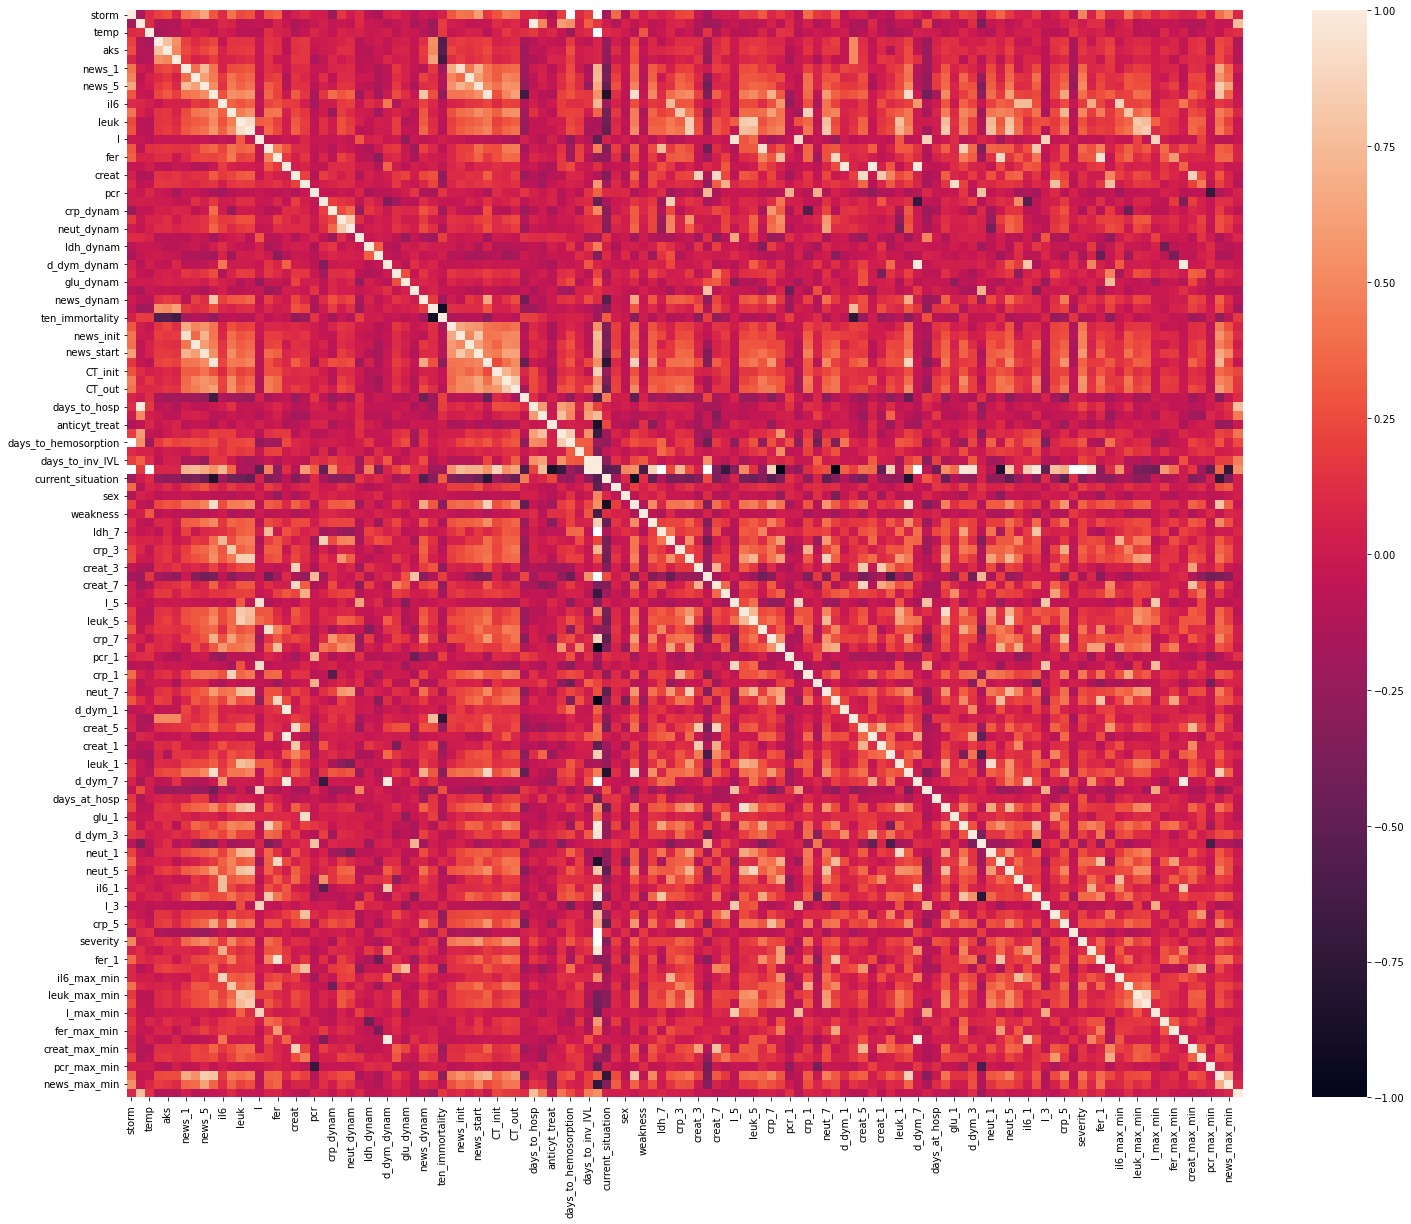

In [9]:
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(data.drop(["launch_id", "man_id"], axis=1).corr())
# plt.savefig("heatmap.pdf")
# plt.show()

#### Save data for r boxplots

In [10]:
cols_to_import = [
    "il6",
    "crp",
    "leuk",
    "neut",
    "l",
    "ldh",
    "fer",
    "d_dym",
    "creat",
    "glu",
    "pcr",
    "news",
    "CT_start",
    "death",
    "severity",
]
data[cols_to_import].to_csv(PHENO_FOR_R_PLOTS, sep="\t", index=False)

## Overall distribution

Let's build distributions for all the columns, just to look at the data.

In [11]:
id_cols = ["man_id", "launch_id"]

categorical_cols = [
    "BACT_sum",
    "age",
    "sex",
    "death",
    "severity",
    "smell_taste_loss",
    "storm",
    "week_to_hosp",
    "smell_taste_loss",
    "news",
    "news_1",
    "news_5",
    "news_dynam",
    "news_init",
    "news_start",
    "news_out",
    "news_max_min",
    "current_situation",
    "resp_dis_init",
    "resp_dis_start",
    "resp_dis_out",
    "temp",
    "ten_immortality",
    "weakness",
    "CT_features",
    "CT_init",
    "CT_out",
    "CT_start",
    "com_index"
]

dont_check_cols = ["treatment", "date_in", "date_out"]

numerical_cols = list(
    set(data.columns) - set(id_cols) - set(categorical_cols) - set(dont_check_cols)
)

In [12]:
draw_histplots(data, numerical_cols + categorical_cols, draw_first_histplot_flag)

Before doing smth, 
lets make copy data to then use it for saving as data 
without imputing and with only high coverage

In [13]:
high_data = data.copy(deep=True)

In [14]:
high_data

,launch_id,man_id,storm,ill_to_hosp,temp,chd,aks,cvd,news_1,resp_fail_5,...,l_max_min,ldh_max_min,fer_max_min,d_dym_max_min,creat_max_min,glu_max_min,pcr_max_min,news,news_max_min,week_to_hosp
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
104555,10,597619,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.07,0.0,0.0,0.00,5.0,NaN,12.00,0.0,0.0,0.0
1046472,10,263436,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.88,NaN,NaN,0.77,0.0,NaN,NaN,0.0,0.0,0.0
1046474,10,695634,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.92,0.0,NaN,2.32,0.0,NaN,0.00,2.0,0.0,1.0
1046475,10,694025,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.60,NaN,NaN,5.64,8.0,0.60,NaN,0.0,0.0,1.0
1046476,10,74079,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.23,0.0,0.0,5.84,211.0,2.80,8.00,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114118,11,660644,1.0,8.0,1.0,0.0,0.0,0.0,6.0,3.0,...,0.87,0.0,49.7,NaN,3.0,0.00,0.00,11.0,9.0,1.0
114119,11,660141,1.0,7.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.48,NaN,434.2,1.58,11.0,5.75,7.90,5.0,5.0,0.0
114120,11,29478,1.0,3.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.43,0.0,9.4,0.00,NaN,NaN,0.00,4.0,4.0,NaN


In [15]:
high_coverage(high_data, 55)
high_coverage(high_data, 70)
cov_75_cols = high_coverage(high_data, 75)
high_coverage(high_data, 85)
high_coverage(high_data, 95)
high_coverage(high_data, 99)

Values > 55%: Counter({True: 84, False: 43})
Values > 70%: Counter({False: 64, True: 63})
Values > 75%: Counter({False: 73, True: 54})
Values > 85%: Counter({False: 79, True: 48})
Values > 95%: Counter({False: 97, True: 30})
Values > 99%: Counter({False: 107, True: 20})


['launch_id',
 'man_id',
 'news_dynam',
 'treatment',
 'com_index',
 'ten_immortality',
 'news_init',
 'resp_dis_start',
 'news_start',
 'resp_dis_out',
 'days_to_hosp',
 'BACT_sum',
 'sex',
 'age',
 'news_out',
 'days_at_hosp',
 'severity',
 'news',
 'news_max_min',
 'week_to_hosp']

In [16]:
high_data_deleted = list(set(high_data.columns) - set(cov_75_cols))
high_data = high_data[cov_75_cols]
high_data.shape

(840, 54)

In [17]:
len(set(high_data.columns)  & set(numerical_cols))

26

In [18]:
len(set(high_data.columns)  & set(categorical_cols))

25

## Ditributions of coverages: 

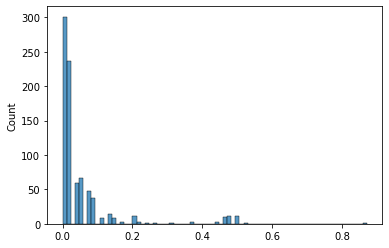

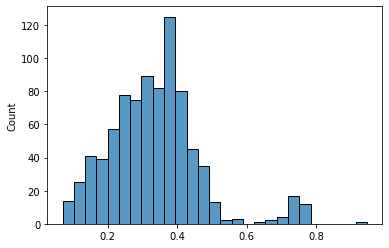

In [19]:
nans_by_man = []
for key, row in high_data.iterrows():
    nans_by_man.append(row.isnull().sum() / high_data.shape[1])
sns.histplot(nans_by_man)
plt.show()


nans_by_man = []
for key, row in data.iterrows():
    nans_by_man.append(row.isnull().sum() / data.shape[1])
sns.histplot(nans_by_man)
plt.show()

## Delete outliers

We want to __delete outliers__ (let's take $3 \sigma$ to the left and to the right) - that is just for numerical colimns.

In [20]:
masked_data = delete_outliers(data, sd=3)
masked_high_data = delete_outliers(high_data, sd=3)

draw_histplots(masked_data, numerical_cols, draw_histplots_flag)

/home/achangalidi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


## Boxplots

In [21]:
if draw_boxplots_flag:
    for cat_col in categorical_cols:
        print(f"=====\n{cat_col.upper()}\n=====")
        for num_col in numerical_cols:
            print(f"-----\n{num_col}\n-----")
            if cat_col == "age":
                sns.set(rc={"figure.figsize": (19, 8)})
                plt.xticks(rotation=90)
            else:
                sns.set(rc={"figure.figsize": (10, 5)})
                plt.xticks(rotation=0)
            sns.boxplot(y=masked_data[num_col], x=masked_data[cat_col])
            plt.show()

## PCA

Объясненная дисперсия: [0.1764511  0.05713059]


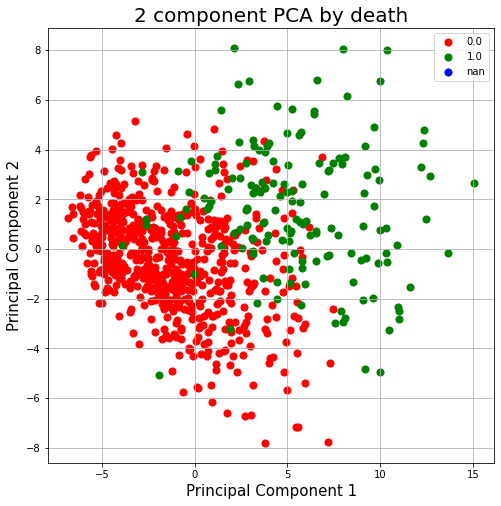

In [22]:
target = "death"
pca_data_death = do_pca(masked_data, target)
draw_pca(pca_data_death, target)

In [23]:
pca_data_death.rename(
    columns={
        "principal component 1": "PC1 (17.78%)",
        "principal component 2": "PC2 (5.84%)",
    }
)

,PC1 (17.78%),PC2 (5.84%),death
launch_blood_id,,,
104555,-5.250053,0.321875,0.0
1046472,-1.722793,-1.489034,0.0
1046474,1.934653,-1.856784,0.0
1046475,0.399345,-2.023677,0.0
1046476,3.710726,2.465948,0.0
...,...,...,...
114118,1.164563,-4.639162,0.0
114119,1.350463,-0.535805,0.0
114120,-3.289684,-0.425559,NaN


In [24]:
pca_data_death.rename(
    columns={
        "principal component 1": "PC1",
        "principal component 2": "PC2",
    }
).to_csv(DRAW_DATA_DEATH_PCA, sep="\t")

Объясненная дисперсия: [0.27362683 0.11848388]


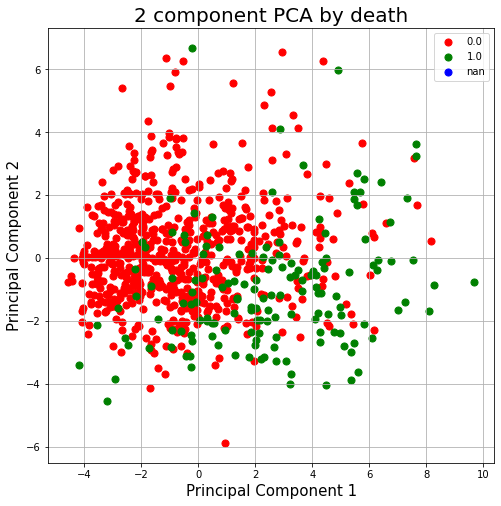

In [25]:
pca_high_data_death = do_pca(masked_high_data, target)
draw_pca(pca_high_data_death, target)

Объясненная дисперсия: [0.1764511 0.0571306]


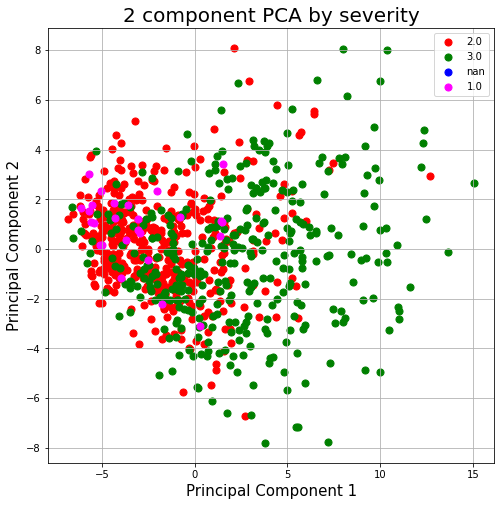

In [26]:
target = "severity"
pca_data_severity = do_pca(masked_data, target)
draw_pca(
    pca_data_severity,
    target,
)

In [27]:
pca_data_death.head()

,principal component 1,principal component 2,death
launch_blood_id,,,
104555,-5.250053,0.321875,0.0
1046472,-1.722793,-1.489034,0.0
1046474,1.934653,-1.856784,0.0
1046475,0.399345,-2.023677,0.0
1046476,3.710726,2.465948,0.0


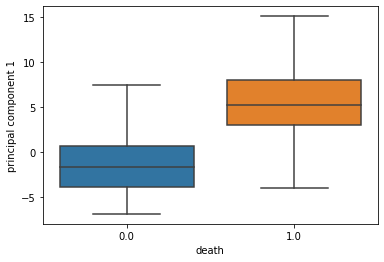

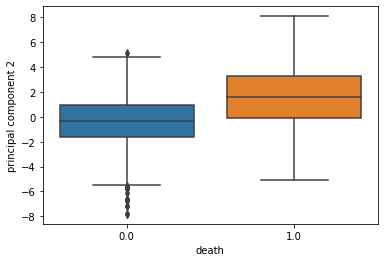

In [28]:
sns.boxplot(y=pca_data_death["principal component 1"], x=pca_data_death["death"])
plt.show()
sns.boxplot(y=pca_data_death["principal component 2"], x=pca_data_death["death"])
plt.show()

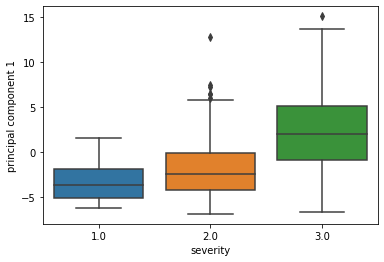

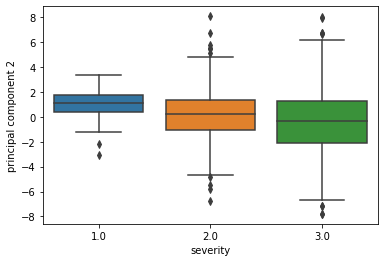

In [29]:
sns.boxplot(
    y=pca_data_severity["principal component 1"], x=pca_data_severity["severity"]
)
plt.show()
sns.boxplot(
    y=pca_data_severity["principal component 2"], x=pca_data_severity["severity"]
)
plt.show()

### By sex

Объясненная дисперсия: [0.1764511 0.0571306]


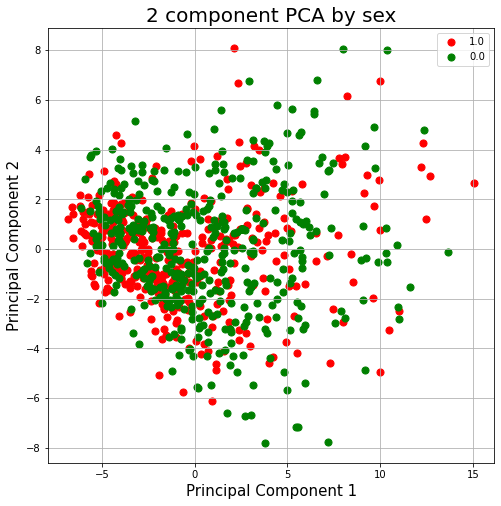

In [30]:
target = "sex"
pca_data_sex = do_pca(masked_data, target)
draw_pca(pca_data_sex, target)

In [31]:
pca_data_sex.rename(
    columns={
        "principal component 1": "PC1",
        "principal component 2": "PC2",
    }
).to_csv(DRAW_DATA_SEX_PCA, sep="\t")

## Saving dataset
Final pipeline: filter (delete outliers) ->  add PCAs -> INT normalization -> save

In [32]:
masked_data["pc1"] = pca_data_death["principal component 1"]
masked_data["pc2"] = pca_data_death["principal component 2"]

In [33]:
set(categorical_cols) & set(cov_75_cols)

{'BACT_sum',
 'CT_features',
 'CT_init',
 'CT_out',
 'CT_start',
 'age',
 'com_index',
 'current_situation',
 'death',
 'news',
 'news_dynam',
 'news_init',
 'news_max_min',
 'news_out',
 'news_start',
 'resp_dis_init',
 'resp_dis_out',
 'resp_dis_start',
 'severity',
 'sex',
 'smell_taste_loss',
 'storm',
 'ten_immortality',
 'weakness',
 'week_to_hosp'}

In [34]:
numerical_cols = [
    "creat",
    "creat_1",
    "creat_dynam",
    "creat_max_min",
    "crp",
    "crp_1",
    "crp_dynam",
    "crp_max_min",
    "days_at_hosp",
    "days_to_hosp",
    "l",
    "l_1",
    "l_3",
    "l_dynam",
    "l_max_min",
    "leuk",
    "leuk_1",
    "leuk_3",
    "leuk_7",
    "leuk_dynam",
    "leuk_max_min",
    "neut",
    "neut_1",
    "neut_3",
    "neut_dynam",
    "neut_max_min",
    "pc1",
    "pc2",
]

id_cols = ["man_id", "launch_id"]
categorical_cols = [
    "BACT_sum",
    "CT_features",
    "CT_init",
    "CT_out",
    "CT_start",
    "age",
    "com_index",
    "current_situation",
    "death",
    "news",
    "news_dynam",
    "news_init",
    "news_max_min",
    "news_out",
    "news_start",
    "resp_dis_init",
    "resp_dis_out",
    "resp_dis_start",
    "severity",
    "sex",
    "smell_taste_loss",
    "storm",
    "ten_immortality",
    "weakness",
    "week_to_hosp",
]
dont_check_cols = ["treatment"]
all_cols = id_cols + categorical_cols + numerical_cols + dont_check_cols
print(len(all_cols))

56


In [35]:
irnt_comparison_before = masked_data[numerical_cols]
irnt_comparison_before = irnt_comparison_before.add_suffix(' before IRNT')

In [36]:
int_masked_data = masked_data.copy(deep=True)

int_masked_data = int_masked_data.rename(
    columns={"10_immortality": "ten_days_immortality"}
)

int_masked_data.sex = int_masked_data.sex.astype(int)
int_masked_data["pc1"] = pca_data_death["principal component 1"]
int_masked_data["pc2"] = pca_data_death["principal component 2"]

int_masked_data.to_csv(PHENO_UNNORM_TO_SAVE, sep="\t")

int_masked_data = int_masked_data[list(high_data.columns) + ['pc1', 'pc2']]

for col in set(numerical_cols) & set(high_data.columns):
    #     print(col)
    int_masked_data[col] = rank_INT(int_masked_data[col], c=3.0 / 8, stochastic=True)

int_masked_data.to_csv(PHENO_TO_SAVE, sep="\t")

In [37]:
irnt_comparison_after = int_masked_data[numerical_cols]
irnt_comparison_after = irnt_comparison_after.add_suffix(' after IRNT')


In [38]:
irnt_comparison_after

,creat after IRNT,creat_1 after IRNT,creat_dynam after IRNT,creat_max_min after IRNT,crp after IRNT,crp_1 after IRNT,crp_dynam after IRNT,crp_max_min after IRNT,days_at_hosp after IRNT,days_to_hosp after IRNT,...,leuk_7 after IRNT,leuk_dynam after IRNT,leuk_max_min after IRNT,neut after IRNT,neut_1 after IRNT,neut_3 after IRNT,neut_dynam after IRNT,neut_max_min after IRNT,pc1 after IRNT,pc2 after IRNT
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
104555,-0.333425,-0.665379,0.966979,-0.282504,-1.189100,-1.115705,0.147550,-0.683442,0.166915,-0.907882,...,-1.281552,-0.755442,1.291978,-0.170263,-0.747168,0.302957,-0.537327,0.587953,-5.250053,0.321875
1046472,0.155156,0.306479,0.388952,-0.916981,0.518273,0.798654,-1.084957,0.725092,0.794024,0.065590,...,-0.295056,-0.937849,-0.021155,-0.143870,0.205045,-0.748193,-0.610233,0.146779,-1.722793,-1.489034
1046474,-0.466717,-0.325028,0.669017,-0.613985,0.718649,1.002797,-0.942933,0.603477,0.276317,0.651465,...,1.290853,0.230723,1.561236,1.212766,1.691557,0.599284,-2.442012,1.769423,1.934653,-1.856784
1046475,-0.372332,-0.874387,-0.086630,-0.043160,0.456211,-0.649698,-0.055568,1.009356,1.238402,1.265094,...,1.137876,1.616910,0.514902,0.349110,0.276051,0.508517,1.047142,-0.246222,0.399345,-2.023677
1046476,2.194859,2.352346,-2.698284,NaN,1.264784,1.559466,-1.972522,1.754082,-0.524575,1.299781,...,-0.718228,-2.595355,1.682343,1.098427,1.545709,1.022658,-2.382357,1.696510,3.710726,2.465948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114118,-1.439005,-1.629852,0.870545,-0.398626,-0.590099,-0.437775,-0.234079,-0.219506,2.266654,0.647701,...,0.316367,1.204457,0.281934,0.203424,-1.130099,0.667237,1.379299,0.631002,1.164563,-4.639162
114119,-1.050828,-1.124447,-0.529562,0.076410,1.089839,-0.062684,0.869057,1.124172,-0.304938,0.145313,...,NaN,1.084957,-0.614158,0.022812,-0.394223,0.491715,1.160858,-0.032507,1.350463,-0.535805
114120,NaN,NaN,NaN,NaN,-0.677290,-0.538624,0.088324,-0.638955,-0.827908,NaN,...,NaN,NaN,NaN,0.562742,0.939397,NaN,0.218129,-1.890651,-3.289684,-0.425559


In [39]:
comparison_data = pd.concat([irnt_comparison_before, irnt_comparison_after], axis = 1)
comparison_data

,creat before IRNT,creat_1 before IRNT,creat_dynam before IRNT,creat_max_min before IRNT,crp before IRNT,crp_1 before IRNT,crp_dynam before IRNT,crp_max_min before IRNT,days_at_hosp before IRNT,days_to_hosp before IRNT,...,leuk_7 after IRNT,leuk_dynam after IRNT,leuk_max_min after IRNT,neut after IRNT,neut_1 after IRNT,neut_3 after IRNT,neut_dynam after IRNT,neut_max_min after IRNT,pc1 after IRNT,pc2 after IRNT
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
104555,73.0,68.0,5.0,5.0,10.6,10.6,-9.1,10.6,13.0,2.0,...,-1.281552,-0.755442,1.291978,-0.170263,-0.747168,0.302957,-0.537327,0.587953,-5.250053,0.321875
1046472,85.0,85.0,0.0,0.0,151.5,151.5,-121.9,121.9,16.0,6.0,...,-0.295056,-0.937849,-0.021155,-0.143870,0.205045,-0.748193,-0.610233,0.146779,-1.722793,-1.489034
1046474,71.0,71.0,0.0,0.0,177.9,177.9,-108.8,108.8,13.0,8.0,...,1.290853,0.230723,1.561236,1.212766,1.691557,0.599284,-2.442012,1.769423,1.934653,-1.856784
1046475,72.0,65.0,-1.0,8.0,146.4,23.1,-21.7,145.0,19.0,11.0,...,1.137876,1.616910,0.514902,0.349110,0.276051,0.508517,1.047142,-0.246222,0.399345,-2.023677
1046476,270.0,213.0,-154.0,NaN,247.7,247.7,-235.7,235.7,10.0,12.0,...,-0.718228,-2.595355,1.682343,1.098427,1.545709,1.022658,-2.382357,1.696510,3.710726,2.465948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114118,59.0,56.0,3.0,3.0,37.8,37.8,-35.3,35.3,29.0,8.0,...,0.316367,1.204457,0.281934,0.203424,-1.130099,0.667237,1.379299,0.631002,1.164563,-4.639162
114119,64.0,62.0,-9.0,11.0,223.8,69.0,3.9,154.8,10.0,7.0,...,NaN,1.084957,-0.614158,0.022812,-0.394223,0.491715,1.160858,-0.032507,1.350463,-0.535805
114120,NaN,NaN,NaN,NaN,31.7,31.7,-11.8,11.8,9.0,NaN,...,NaN,NaN,NaN,0.562742,0.939397,NaN,0.218129,-1.890651,-3.289684,-0.425559


In [40]:
comparison_data = comparison_data.stack().reset_index(level=0, drop=True).reset_index()
comparison_data.columns = ['feature', 'value']
comparison_data.sort_values(['feature', 'value'], inplace=True)
comparison_data.to_csv('./draw_data/for_big_plot.tsv', sep = '\t', index=False)
comparison_data

,feature,value
28766,creat after IRNT,-3.145633
17292,creat after IRNT,-2.854614
19198,creat after IRNT,-2.698725
20578,creat after IRNT,-2.589477
40018,creat after IRNT,-2.504460
...,...,...
11275,pc2 before IRNT,6.775126
24329,pc2 before IRNT,6.783834
32267,pc2 before IRNT,7.991199
38040,pc2 before IRNT,8.038037


In [41]:
for c1, c2 in zip(irnt_comparison_before.columns, irnt_comparison_after.columns):
    print(f'\'{c1}\', \'{c2}\', ', end = '')

'creat before IRNT', 'creat after IRNT', 'creat_1 before IRNT', 'creat_1 after IRNT', 'creat_dynam before IRNT', 'creat_dynam after IRNT', 'creat_max_min before IRNT', 'creat_max_min after IRNT', 'crp before IRNT', 'crp after IRNT', 'crp_1 before IRNT', 'crp_1 after IRNT', 'crp_dynam before IRNT', 'crp_dynam after IRNT', 'crp_max_min before IRNT', 'crp_max_min after IRNT', 'days_at_hosp before IRNT', 'days_at_hosp after IRNT', 'days_to_hosp before IRNT', 'days_to_hosp after IRNT', 'l before IRNT', 'l after IRNT', 'l_1 before IRNT', 'l_1 after IRNT', 'l_3 before IRNT', 'l_3 after IRNT', 'l_dynam before IRNT', 'l_dynam after IRNT', 'l_max_min before IRNT', 'l_max_min after IRNT', 'leuk before IRNT', 'leuk after IRNT', 'leuk_1 before IRNT', 'leuk_1 after IRNT', 'leuk_3 before IRNT', 'leuk_3 after IRNT', 'leuk_7 before IRNT', 'leuk_7 after IRNT', 'leuk_dynam before IRNT', 'leuk_dynam after IRNT', 'leuk_max_min before IRNT', 'leuk_max_min after IRNT', 'neut before IRNT', 'neut after IRNT', 